En este libro se realiza un ejercicio de regresión empleando Pytorch-Lightning.

Para esto se va a usar el conjutno de datos MPG, que contiene información sobre el consumo de gasolina de diferentes tipos de carro y sus respectivas características.

A continuación se cargan los paquetes a usar:


In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import LightningModule
import torch
from torch import nn
from torchvision.transforms import ToTensor
import torch.nn.functional as F
!pip install livelossplot
from livelossplot import PlotLosses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se usa pandas para cargar la base de datos desde una URL como un data frame.

In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data", header=None, sep="\s+",usecols=[0,1,2,3,4,5,6,7],names=['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


Observando la base de datos, algunos datos fueron cargados como texto y en lugar de NaN, se asignó el signo "?", por lo que se va a reemplazar.

In [3]:
df=df.replace({"?":np.nan})

Ahora se confirma la presencia de valores perdidos y se eliminan esos registros por facilidad para este ejercicio.

Adicionalmente, la variable "Horsepower" se declara como numérica.

In [4]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
df=df.dropna()
df["Horsepower"]=pd.to_numeric(df["Horsepower"])
df["MPG"]=df["MPG"].astype(float)
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [6]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


A continuación se generan variables dummy según el país de origen del modelo de automóvil y se reemplaza la variable origin por las nuevas dummies generadas.

In [7]:
df2=pd.get_dummies(df["Origin"])
df2.columns=['USA','Europe','Japan']
df2

,USA,Europe,Japan
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
393,1,0,0
394,0,1,0
395,1,0,0
396,1,0,0


In [8]:
frames=[df,df2]
df=pd.concat([df,df2],axis=1)
df = df.drop('Origin', 1)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0


A continuación se generan conjuntos de entramiento y de prueba. Para garantizar la replicabilidad, se incluye una semilla aleatoria.

In [9]:
train_dataset = df.sample(frac=0.8,random_state=12)
test_dataset = df.drop(train_dataset.index)

Se generan gráficos para analizar la relación entre la variable de interés "MPG" y algunas regresoras.

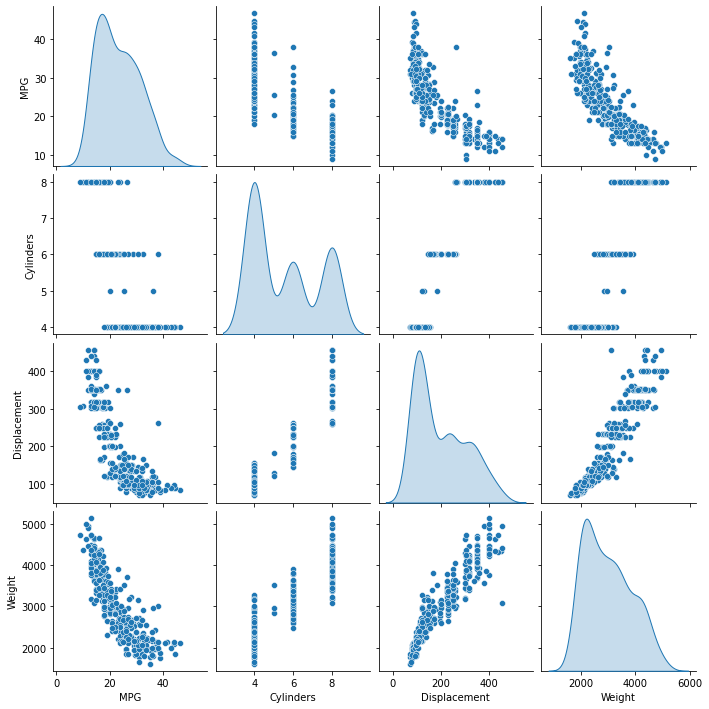

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

A continuación, se extrae la variable "MPG" y se calculan estadísticas de resumen de las regresoras con el fin de normalizar los datos para la regresión.

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.576433,1.698210,4.0,4.00,6.0,8.00,8.0
Displacement,314.0,200.246815,106.369828,71.0,105.00,156.0,302.00,455.0
Horsepower,314.0,105.117834,38.879951,46.0,76.00,95.0,130.00,230.0
Weight,314.0,2997.808917,856.314102,1613.0,2219.25,2900.5,3618.25,5140.0
Acceleration,314.0,15.488854,2.805364,8.0,13.50,15.5,17.00,24.8
Model Year,314.0,75.987261,3.777328,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.640127,0.480729,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.156051,0.363483,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.00,0.0,0.00,1.0


In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data = normed_train_data.astype(float)
normed_data = pd.concat([normed_train_data,normed_test_data])
labels = pd.concat([train_labels,test_labels])

La regresión en pytorch se realiza a partir de tensores, por lo que se definen los conjuntos de datos como tensores de tipo float32

In [14]:
X_train = torch.tensor(np.array(normed_train_data), dtype= torch.float32)
X_test = torch.tensor(np.array(normed_test_data), dtype= torch.float32)
Y_train = torch.tensor(np.array(train_labels), dtype= torch.float32)
Y_test = torch.tensor(np.array(test_labels), dtype= torch.float32)

Se define el modelo

In [15]:
inputDim=X_train.size(1)
outputDim=1

In [16]:
class Linear(LightningModule):
 
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(inputDim, outputDim) 
 
    def forward(self, x):
        y_pred = self.linear(x).squeeze(1)
        return y_pred

In [17]:
learningRate = 2 
epochs = 60

linear_model = Linear()

In [18]:
optim = torch.optim.Adam(linear_model.parameters(), lr=learningRate)
loss_function = F.mse_loss

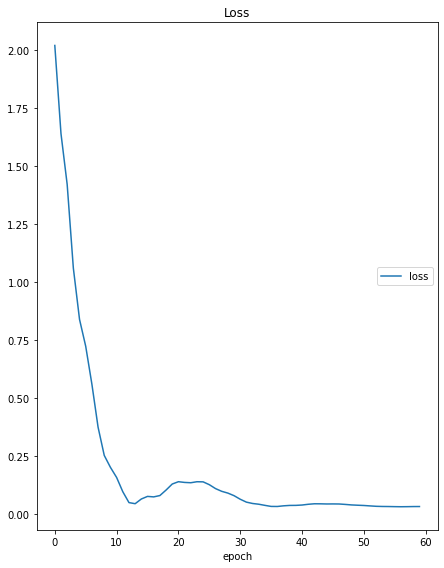

Loss
	loss             	 (min:    0.032, max:    2.019, cur:    0.033)


In [19]:
def train(normed_data, labels, model, loss_function, optim, num_epochs):
    loss_history = []
    liveloss = PlotLosses()


    for epoch in range(num_epochs):
        
        epoch_loss = 0.01
        
        Y_pred = model(X_train)
        loss = loss_function(Y_pred, Y_train)
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        

        epoch_loss = loss.data.item()
        
        avg_loss = epoch_loss / len(X_train)

        liveloss.update({
            'loss': avg_loss,
        })
        liveloss.draw()

train(normed_train_data, train_labels, linear_model, loss_function, optim, num_epochs=epochs)

Una vez definido el modelo se procede a analizar los errores cuadráticos medios de las predicciones obtenidas a partir del modelo ajustado. Este cálculo se realiza tanto para los datos de entrenamiento como para los de prueba y se observa que el rendimiento es similar en ambos casos.

In [20]:
y_predict_train = linear_model(X_train)
rmse_train = torch.sqrt(F.mse_loss(Y_train, y_predict_train))

y_predict_test = linear_model(X_test)
rmse_test = torch.sqrt(F.mse_loss(Y_test, y_predict_test))

print("El desempeño del modelo usando Lightning es:")
print('RMSE entrenamiento: {}'.format(rmse_train))
print('RMSE prueba: {}'.format(rmse_test))

El desempeño del modelo usando Lightning es:
RMSE entrenamiento: 3.2211177349090576
RMSE prueba: 3.9132189750671387


A continuación se grafican los valores predichos vs los observados en el conjunto de prueba. Se puede concluir que el ajuste del modelo es bueno, aunque posiblemente podría mejorar.

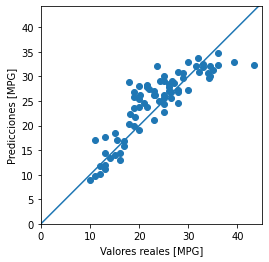

In [21]:
plt.scatter(test_labels, torch.detach(y_predict_test).numpy())
plt.xlabel('Valores reales [MPG]')
plt.ylabel('Predicciones [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Se grafican los residuales del modelo para analizar su distribución, parece que no son normales por lo que se podría ajustar el modelo para futuros ejercicios.

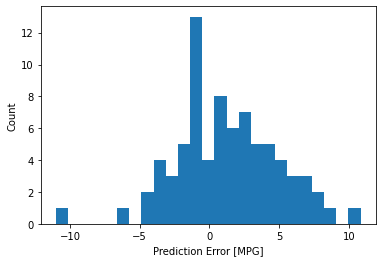

In [22]:
error = torch.detach(y_predict_test) - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")